In [1]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import tensorflow as tf
from adapt.ml.dl_subclass import MLP, MLPprop, CNN, CNNprop, get_train, get_test
import adapt.utils.data_utils as prd
from adapt.ml.lda import train_lda, eval_lda
import adapt.loop as lp
import matplotlib.pyplot as plt

set_gpu()

Using TensorFlow backend.


Num GPUs Available:  1


In [53]:
path = 'C:/Users/yteh/Documents/work/necal/home data/TR58/DATA/MAT/'
all_files = os.listdir(path)
train_file = all_files[1]

In [26]:
all_files = np.delete(all_files,0)

In [27]:
train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
train_data = train_data[:,:8,:]

train_dof = np.unique(train_params[:,2])
key = np.empty(train_dof.shape)
for i in range(len(train_dof)):
    key[i] = train_params[np.argmax(train_params[:,2] == train_dof[i]),0]

In [28]:
# Initial training
ep = 30
n_dof = len(train_dof)

trainmlp, traincnn, y_train, x_train_mlp, x_train_cnn, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False)
mlp, cnn, w, c = lp.train_models(traincnn, trainmlp, x_train_lda, y_train_lda, n_dof, ep)

In [40]:
# Test all controllers without recalibration or adaptation
acc = np.empty((len(all_files),3))

for i in range(1,len(all_files)):
    # load data
    test_file = all_files[i]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=len(train_dof))
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, w, c)

    print ('Set: ' + test_file, f'CNN Accuracy: {acc[i,0]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,2]:.2f}')

Set: 20170730_055812 CNN Accuracy: 72.95, MLP Accuracy: 72.27, LDA Accuracy: 69.62
Set: 20170730_060537 CNN Accuracy: 73.28, MLP Accuracy: 72.95, LDA Accuracy: 69.49
Set: 20170730_123937 CNN Accuracy: 72.57, MLP Accuracy: 69.41, LDA Accuracy: 62.62
Set: 20170731_123147 CNN Accuracy: 64.35, MLP Accuracy: 67.38, LDA Accuracy: 57.90
Set: 20170801_053500 CNN Accuracy: 66.88, MLP Accuracy: 67.17, LDA Accuracy: 58.79
Set: 20170801_054938 CNN Accuracy: 66.46, MLP Accuracy: 61.23, LDA Accuracy: 57.82
Set: 20170801_065547 CNN Accuracy: 65.74, MLP Accuracy: 63.51, LDA Accuracy: 47.16
Set: 20170802_050945 CNN Accuracy: 69.66, MLP Accuracy: 70.88, LDA Accuracy: 63.76
Set: 20170802_051732 CNN Accuracy: 69.45, MLP Accuracy: 74.21, LDA Accuracy: 70.71
Set: 20170802_052140 CNN Accuracy: 69.79, MLP Accuracy: 69.87, LDA Accuracy: 57.02
Set: 20170807_153152 CNN Accuracy: 64.69, MLP Accuracy: 65.15, LDA Accuracy: 68.90
Set: 20170807_153559 CNN Accuracy: 58.79, MLP Accuracy: 59.97, LDA Accuracy: 57.23
Set:

In [8]:
# Test all controllers with recalibration
ep = 30
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
recal_acc = np.empty((len(all_files),3))
recal_acc[:] = np.nan

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    recal_file = all_files[i]
    recal_data, recal_params = prd.load_caps_train(path + recal_file + '/traindata.mat')
    recal_data = recal_data[:,:8,:]

    recal_dof = np.unique(recal_params[:,2])
    recal_key = np.empty(recal_dof.shape)
    for dof_i in range(len(recal_dof)):
        recal_key[dof_i] = recal_params[np.argmax(recal_params[:,2] == recal_dof[dof_i]),0]
    recal_dof = len(recal_dof)
    
    recalmlp, recalcnn, _, _, _, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(recal_data, recal_params, prop_b = False)
    mlp, cnn, w, c = lp.train_models(recalcnn, recalmlp, x_train_lda, y_train_lda, recal_dof, ep)
    
    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,recal_dof,recal_key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=recal_dof)
    recal_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, w, c)

    print ('Recal: ' + recal_file + ', Test: ' + test_file, f', CNN Accuracy: {recal_acc[i+1,0]:.2f},', f'MLP Accuracy: {recal_acc[i+1,1]:.2f},', f'LDA Accuracy: {recal_acc[i+1,2]:.2f}')

Recal: 20170730_055812, Test: 20170730_060537 , CNN Accuracy: 78.17, MLP Accuracy: 73.87, LDA Accuracy: 71.09
Recal: 20170730_123937, Test: 20170731_123147 , CNN Accuracy: 68.31, MLP Accuracy: 61.78, LDA Accuracy: 50.74
Recal: 20170801_053500, Test: 20170801_054938 , CNN Accuracy: 62.20, MLP Accuracy: 64.98, LDA Accuracy: 56.93
Recal: 20170801_065547, Test: 20170802_050945 , CNN Accuracy: 71.05, MLP Accuracy: 72.31, LDA Accuracy: 68.27
Recal: 20170802_051732, Test: 20170802_052140 , CNN Accuracy: 67.72, MLP Accuracy: 63.34, LDA Accuracy: 50.74
Recal: 20170807_153152, Test: 20170807_153559 , CNN Accuracy: 66.29, MLP Accuracy: 70.71, LDA Accuracy: 58.74
Recal: 20170808_054353, Test: 20170808_063929 , CNN Accuracy: 68.35, MLP Accuracy: 68.48, LDA Accuracy: 65.87
Missing classes
Recal: 20170808_104400, Test: 20170913_053927 , CNN Accuracy: 54.35, MLP Accuracy: 56.27, LDA Accuracy: 10.72
Recal: 20170913_061042, Test: 20170915_173323 , CNN Accuracy: 65.96, MLP Accuracy: 71.84, LDA Accuracy: 

In [20]:
# Test all controllers with adaptation
ep = 5
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
adapt_acc = np.empty((len(all_files),3))
adapt_acc[:] = np.nan
n_dof = len(train_dof)

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    adapt_file = all_files[i]
    adapt_data, adapt_params = prd.load_caps_train(path + adapt_file + '/traindata.mat')
    adapt_data = adapt_data[:,:8,:]

    # check class labels
    adapt_data, adapt_params = lp.check_labels(adapt_data, adapt_params, train_dof, key)
    
    adaptmlp, adaptcnn, _, _, _, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(adapt_data, adapt_params, prop_b = False, num_classes=n_dof)
    mlp, cnn, w, c = lp.train_models(adaptcnn, adaptmlp, x_train_lda, y_train_lda, n_dof, ep, mlp, cnn)
    
    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof)
    adapt_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, w, c)

    print ('Adapt: ' + adapt_file + ', Test: ' + test_file, f', CNN Accuracy: {adapt_acc[i+1,0]:.2f},', f'MLP Accuracy: {adapt_acc[i+1,1]:.2f},', f'LDA Accuracy: {adapt_acc[i+1,2]:.2f}')

Adapt: 20170730_055812, Test: 20170730_060537 , CNN Accuracy: 80.19, MLP Accuracy: 80.32, LDA Accuracy: 71.09
Adapt: 20170730_123937, Test: 20170731_123147 , CNN Accuracy: 67.30, MLP Accuracy: 70.04, LDA Accuracy: 50.74
Adapt: 20170801_053500, Test: 20170801_054938 , CNN Accuracy: 64.64, MLP Accuracy: 71.22, LDA Accuracy: 56.93
Adapt: 20170801_065547, Test: 20170802_050945 , CNN Accuracy: 70.46, MLP Accuracy: 72.36, LDA Accuracy: 68.27
Adapt: 20170802_051732, Test: 20170802_052140 , CNN Accuracy: 68.31, MLP Accuracy: 65.07, LDA Accuracy: 50.74
Adapt: 20170807_153152, Test: 20170807_153559 , CNN Accuracy: 71.72, MLP Accuracy: 71.98, LDA Accuracy: 58.74
Adapt: 20170808_054353, Test: 20170808_063929 , CNN Accuracy: 70.75, MLP Accuracy: 66.58, LDA Accuracy: 65.87
Missing classes
Adapt: 20170808_104400, Test: 20170913_053927 , CNN Accuracy: 56.27, MLP Accuracy: 61.11, LDA Accuracy: 10.72
Missing classes
Missing classes
Adapt: 20170913_061042, Test: 20170915_173323 , CNN Accuracy: 73.35, MLP

In [33]:
if acc.shape[0] > recal_acc.shape[0]:
    acc = np.delete(acc,-1,axis=0)

In [34]:
nnVlda = acc[:,1] - acc[:,2]
annVlda = adapt_acc[:,1] - acc[:,2]
rnnVlda = recal_acc[:,1] - acc[:,2]
nnVrlda = acc[:,1] - recal_acc[:,2]
annVrlda = adapt_acc[:,1] - adapt_acc[:,2]
rnnVrlda = recal_acc[:,1] - recal_acc[:,2]

In [35]:
mask = ~np.isnan(annVrlda)

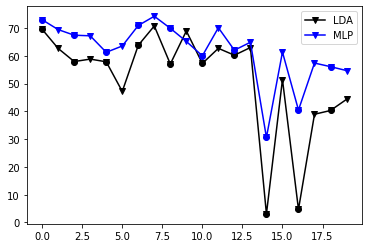

In [52]:
plt.plot(range(0,acc.shape[0]-2,1),acc[range(2,acc.shape[0],1),2],'kv-')
plt.plot(range(0,acc.shape[0]-2,1),acc[range(2,acc.shape[0],1),1],'bv-')
plt.plot(range(0,acc.shape[0]-2,2),acc[range(2,acc.shape[0],2),2],'ko')
plt.plot(range(0,acc.shape[0]-2,2),acc[range(2,acc.shape[0],2),1],'bo')
plt.legend(['LDA','MLP'])

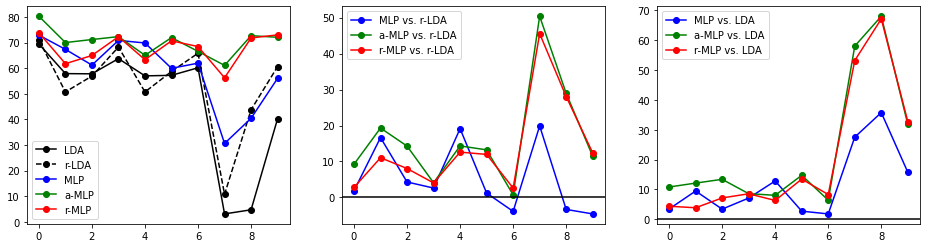

In [36]:


fig,ax = plt.subplots(1,3,figsize=(16,4))

ax[0].plot(acc[mask,2],'ko-')
ax[0].plot(recal_acc[mask,2], 'ko--')
ax[0].plot(acc[mask,1],'bo-')
ax[0].plot(adapt_acc[mask,1], 'go-')
ax[0].plot(recal_acc[mask,1], 'ro-')
ax[0].legend(['LDA', 'r-LDA', 'MLP', 'a-MLP', 'r-MLP'])

ax[1].plot(nnVrlda[mask],'bo-')
ax[1].plot(annVrlda[mask],'go-')
ax[1].plot(rnnVrlda[mask],'ro-')
ax[1].legend(['MLP vs. r-LDA', 'a-MLP vs. r-LDA', 'r-MLP vs. r-LDA'])
ax[1].axhline(0, color='black')

ax[2].plot(nnVlda[mask],'bo-')
ax[2].plot(annVlda[mask],'go-')
ax[2].plot(rnnVlda[mask],'ro-')
ax[2].legend(['MLP vs. LDA', 'a-MLP vs. LDA', 'r-MLP vs. LDA'])
ax[2].axhline(0, color='black')

In [39]:
temp = all_files[:-1]
temp = temp[mask]